In [1]:
import tqdm
import warnings
import multiprocessing
import cvxpy as cp
import numpy as np
import pandas as pd

from functools import partial
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

In [2]:
SAVE_PATH = "./figures"

In [3]:
def check_feasibility(L, a, b):
    x = cp.Variable(len(a))
    constraints = [x <= 2*(b - L)/a, x >= 0, cp.sum(x) == L]
    problem = cp.Problem(cp.Maximize(0), constraints)
    problem.solve()    
    return problem.status in {"optimal", "feasible"}


def solve_fixed_load(L, a, b, metric):

    try: 
        warnings.simplefilter("error")
        if not check_feasibility(L, a, b):
            raise ValueError("infeasible")

        x = cp.Variable(len(a))

        if (metric == "sw") or (metric == 0):
            objective = cp.Maximize(cp.sum(-0.5*cp.multiply(a, x**2) + cp.multiply(b - L, x)))
        elif (metric == "pf") or (metric == 1):
            objective = cp.Maximize(cp.sum(cp.log(x) + cp.log(cp.multiply(-0.5*a, x) + b - L)))
        elif (metric == "mm") or (metric == float("inf")):
            objective = cp.Maximize(cp.min(-0.5*cp.multiply(a, x**2) + cp.multiply(b - L, x)))
        else:
            y = -0.5*cp.multiply(a, x**2) + cp.multiply(b - L, x)
            objective = cp.Maximize(cp.sum(cp.power(y, 1 - metric))/(1 - metric))

        constraints = [x <= 2*(b - L)/a, x >= 0, cp.sum(x) == L]
        problem = cp.Problem(objective, constraints)
        problem.solve(solver="ECOS", abstol=1e-6)

        user_surplus = -0.5*a*x.value**2 + (b - L)*x.value
        surplus = np.sum(user_surplus)

        return problem.value, x.value, user_surplus, surplus
    
    except (Warning, cp.SolverError, TypeError, ValueError) as e:
        return np.nan, np.full(len(a), np.nan), np.full(len(a), np.nan), np.nan
    

## Convex Feasible Region

In [4]:
def solve(a, b, metric):
    pool = multiprocessing.Pool(min(multiprocessing.cpu_count(), 100))
    results = pool.map(partial(solve_fixed_load, a=a, b=b, metric=metric), np.arange(0.001, 1.5, 0.001))
    results = [x for x in results if not np.isnan(x[0])]
    pool.close()
    return sorted(results, key=lambda x: -x[0])[0]

In [5]:
%%time

a = np.array([2, 3])
b = np.array([3, 6])

results1 = []
alpha_values = [0.0, 0.5, 1.0, 2.0, float("inf")]
for alpha in tqdm.tqdm(alpha_values):
    val, sol, user_surplus, surplus = solve(a, b, alpha)
    results1.append(dict(
        alpha=alpha,
        val=val, 
        sol0=sol[0],
        sol1=sol[1],
        sol=sol, 
        user_surplus0=user_surplus[0],
        user_surplus1=user_surplus[1],
        surplus=surplus
    ))
    
results1 = pd.DataFrame(results1)    
results1 = results1.sort_values("user_surplus0", ignore_index=True)    

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.28it/s]

CPU times: user 690 ms, sys: 1.73 s, total: 2.42 s
Wall time: 3.93 s


In [7]:
for alpha, sol0, sol1 in results1[["alpha", "sol0", "sol1"]].values.round(3):
    print(f"{alpha:0.1f}  {sol0:0.3f}  {sol1:0.3f}  {sol0+sol1:0.3f}")

0.0  0.187  1.125  1.312
0.5  0.427  0.911  1.338
1.0  0.535  0.682  1.217
2.0  0.620  0.435  1.055
inf  0.691  0.204  0.895


In [8]:
for alpha, surplus0, surplus1 in results1[["alpha", "user_surplus0", "user_surplus1"]].values.round(3):
    print(f"{alpha:0.1f}  {surplus0:0.3f}  {surplus1:0.3f}  {surplus0+surplus1:0.3f}")

0.0  0.281  3.375  3.656
0.5  0.527  3.003  3.530
1.0  0.668  2.564  3.232
2.0  0.822  1.867  2.689
inf  0.977  0.977  1.954


In [6]:
%%time

# get feasible region
x_grid = np.linspace(0, 2, 1001)
param_list = [(x0, x1, a, b) for x0 in x_grid for x1 in x_grid]

def is_feasible_wrapper(params):
    x0, x1, a, b = params
    L = x0 + x1
    s0 = -0.5*a[0]*x0**2 + (b[0] - L)*x0
    s1 = -0.5*a[1]*x1**2 + (b[1] - L)*x1
    is_feasible = (0 <= x0 <= 2*(b[0] - L)/a[0]) and (0 <= x1 <= 2*(b[1] - L)/a[1])
    is_feasible = is_feasible and (s0 >= 0) and (s1 >= 0)
    return dict(s0=s0, s1=s1, is_feasible=is_feasible)
    
pool = multiprocessing.Pool(min(multiprocessing.cpu_count(), 100))
feasible_region1 = pool.map(is_feasible_wrapper, param_list)
feasible_region1 = pd.DataFrame(feasible_region1).dropna()
feasible_region1 = feasible_region1.loc[feasible_region1.is_feasible, ["s0", "s1"]].reset_index(drop=True)
pool.close()

CPU times: user 3.98 s, sys: 871 ms, total: 4.85 s
Wall time: 4.76 s


## Non-Convex Feasible Region

In [9]:
def solve(a, b, metric):
    pool = multiprocessing.Pool(min(multiprocessing.cpu_count(), 100))
    results = pool.map(partial(solve_fixed_load, a=a, b=b, metric=metric), np.arange(0.1, 100, 0.1))
    results = [x for x in results if not np.isnan(x[0])]
    pool.close()
    return sorted(results, key=lambda x: -x[0])[0]

In [29]:
%%time

a = np.array([2, 2])
b = np.array([40, 4])

results2 = []
alpha_values = [0.0, 0.5, 1.0, 2.0, float("inf")]
for alpha in tqdm.tqdm(alpha_values):
    val, sol, user_surplus, surplus = solve(a, b, alpha)
    results2.append(dict(
        alpha=alpha,
        val=val, 
        sol0=sol[0],
        sol1=sol[1],
        sol=sol, 
        user_surplus0=user_surplus[0],
        user_surplus1=user_surplus[1],
        surplus=surplus
    ))
    
results2 = pd.DataFrame(results2)    
results2 = results2.sort_values("user_surplus0", ignore_index=True)    

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.08s/it]

CPU times: user 527 ms, sys: 4.32 s, total: 4.85 s
Wall time: 5.42 s


In [33]:
for alpha, sol0, sol1 in results2[["alpha", "sol0", "sol1"]].values.round(3):
    print(f"{alpha:0.1f}  {sol0:0.3f}  {sol1:0.3f}  {sol0+sol1:0.3f}")

inf  0.050  0.950  1.000
2.0  0.282  0.918  1.200
1.0  1.325  0.675  2.000
0.5  3.889  0.011  3.900
0.0  4.000  -0.000  4.000


In [34]:
for alpha, surplus0, surplus1 in results2[["alpha", "user_surplus0", "user_surplus1"]].values.round(3):
    print(f"{alpha:0.1f}  {surplus0:0.3f}  {surplus1:0.3f}  {surplus0+surplus1:0.3f}")

inf  1.948  1.947  3.895
2.0  10.876  1.727  12.603
1.0  48.602  0.894  49.496
0.5  125.275  0.001  125.276
0.0  128.000  -0.000  128.000


In [30]:
%%time


# get feasible region
x_grid = np.linspace(0, 10, 1001)
param_list = [(x0, x1, a, b) for x0 in x_grid for x1 in x_grid]
    
pool = multiprocessing.Pool(min(multiprocessing.cpu_count(), 100))
feasible_region2 = pool.map(is_feasible_wrapper, param_list)
feasible_region2 = pd.DataFrame(feasible_region2).dropna()
feasible_region2 = feasible_region2.loc[feasible_region2.is_feasible, ["s0", "s1"]].reset_index(drop=True)
pool.close()

CPU times: user 4.03 s, sys: 1.33 s, total: 5.35 s
Wall time: 5.27 s


## Plot

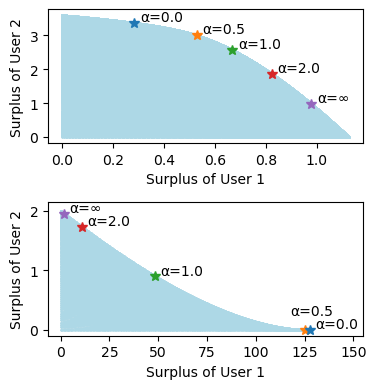

In [32]:
plt.figure(figsize=(4, 4))


plt.subplot(2, 1, 1)
labels = ["α=0.0", "α=0.5", "α=1.0", "α=2.0", "α=∞"]

plt.plot(feasible_region1.s0, feasible_region1.s1, ".", markersize=1, alpha=1, color="lightblue")
for i, (alpha, user_surplus0, user_surplus1) in enumerate(results1[["alpha", "user_surplus0", "user_surplus1"]].values):
    plt.plot(user_surplus0, user_surplus1, "*", markersize=7)
    plt.text(1.2*0.02+user_surplus0, 3*0.02+user_surplus1, labels[i])

plt.xlabel("Surplus of User 1")
plt.ylabel("Surplus of User 2")


plt.subplot(2, 1, 2)
labels = ["α=0.0", "α=0.5", "α=1.0", "α=2.0", "α=∞"][::-1]

plt.plot(feasible_region2.s0, feasible_region2.s1, ".", markersize=1, alpha=1, color="lightblue")
for i, (alpha, user_surplus0, user_surplus1) in enumerate(results2[["alpha", "user_surplus0", "user_surplus1"]].values):
    plt.plot(user_surplus0, user_surplus1, "*", markersize=7, color=f"C{4-i}")
    plt.text(130*0.02+user_surplus0 - 10*(i == 3), 1.5*0.02+user_surplus1 if (i != 3) else 0.25, labels[i])

plt.xlabel("Surplus of User 1")
plt.ylabel("Surplus of User 2")
plt.xlim(None, 155)
plt.ylim(None, 2.15)


plt.tight_layout()
plt.savefig(f"{SAVE_PATH}/pareto-front.png", dpi=300)
plt.show()